In [17]:
import gym
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import CnnPolicy
from stable_baselines3.ppo.policies import MlpPolicy
from utils.adversary_env import AdversaryEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

# Load target model
target_model = A2C.load("../a2c/model/lunarlander_v2_a2c_3M_to_11M")

In [18]:
# Test target model - for info on why the env is wrapped with Monitor check the evaluate_policy function
mean_reward, std_reward = evaluate_policy(target_model, Monitor(gym.make('LunarLander-v2')), n_eval_episodes=50)
print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward: 233.82 +/- 86.30


In [19]:
# Create adversary with adversary env
# adversary_env = AdversaryEnv("LunarLander-v2", target_model)
# adversary = PPO(MlpPolicy, adversary_env, verbose=1)

In [20]:
# Train adversary
# log_dir = "./out/training-log/"
# log_path = log_dir + f"adversary-lunarlander-v2/"
# save_dir = "./models/adversary-lunarlander-v2/"

# timesteps = 50000

# adversary.learn(
#         total_timesteps=timesteps,
#         callback=None,
#         log_interval=-1,
#         eval_env=adversary_env, 
#         eval_freq=5000, 
#         n_eval_episodes=100,
#         tb_log_name='PPO',
#         eval_log_path=log_path, 
#         reset_num_timesteps=False
#         )

# # Save adversary
# adversary.save(save_dir + f"adversary_lunarlander_v2_{timesteps}")

In [21]:
# Load adversary
save_dir = "./models/adversary-lunarlander-v2/"

adversary = PPO.load(save_dir + f"adversary_lunarlander_v2_50000")
adversary_env = AdversaryEnv('LunarLander-v2', target_model)

In [22]:
import numpy as np
import pandas as pd
from uniform_attack import UniformAttack

# Evaluate uniform adversarial attack over different epsilon
data = {
    'epsilon': [],
    'mean_rew': [],
    'mean_perturbation': [],
    'mean_n_timesteps': [],
    'mean_n_attacks': []
}

n_episodes = 50

for j in range(1, 50):
    epsilon = j/100

    all_episodes_rewards = []
    all_episodes_perturbation = []
    all_episodes_n_timesteps = []
    all_episodes_n_attacks = []

    for i in range(0, n_episodes):
        # Run attack on a2c model
        env = gym.make("LunarLander-v2")
        ua = UniformAttack(env=env, model=target_model, attack=adversary, epsilon=epsilon)
        ua.perform_attack()

        all_episodes_rewards.append(ua.reward_total)
        all_episodes_perturbation.append(ua.perturbation_total)
        all_episodes_n_timesteps.append(ua.frames_count)
        all_episodes_n_attacks.append(ua.n_attacks)

        ua.reset_attack()

    data['epsilon'].append(epsilon)
    data['mean_rew'].append(np.round(np.mean(all_episodes_rewards), 2))
    data['mean_perturbation'].append(np.round(np.mean(all_episodes_perturbation), 2))
    data['mean_n_timesteps'].append(np.round(np.mean(all_episodes_n_timesteps), 2))
    data['mean_n_attacks'].append(np.round(np.mean(all_episodes_n_attacks), 2))

    print("------------------------------------------")
    print(
        f"Epsilon {data['epsilon'][-1]}: \n \
        {data['mean_rew'][-1]} mean rew, \n \
        {data['mean_perturbation'][-1]} mean perturbation \n \
        {data['mean_n_timesteps'][-1]} mean n timesteps \n \
        {data['mean_n_attacks'][-1]} mean n attacks"
        )
    print("------------------------------------------")

------------------------------------------
Epsilon 0.01: 
         197.81 mean rew, 
         2.990000009536743 mean perturbation 
         343.06 mean n timesteps 
         343.06 mean n attacks
------------------------------------------
------------------------------------------
Epsilon 0.02: 
         138.48 mean rew, 
         6.289999961853027 mean perturbation 
         359.02 mean n timesteps 
         359.02 mean n attacks
------------------------------------------
------------------------------------------
Epsilon 0.03: 
         95.65 mean rew, 
         11.09000015258789 mean perturbation 
         411.32 mean n timesteps 
         411.32 mean n attacks
------------------------------------------
------------------------------------------
Epsilon 0.04: 
         58.32 mean rew, 
         10.0600004196167 mean perturbation 
         277.52 mean n timesteps 
         277.52 mean n attacks
------------------------------------------
------------------------------------------
Epsi

In [27]:
print(data)

         mean_rew  mean_perturbation  mean_n_timsteps  mean_n_attacks
epsilon                                                              
0.01       197.81               2.99              NaN          343.06
0.02       138.48               6.29              NaN          359.02
0.03        95.65              11.09              NaN          411.32
0.04        58.32              10.06              NaN          277.52
0.05        48.40               9.99              NaN          221.74
0.06        30.79               5.86              NaN          108.08
0.07        26.28               6.80              NaN          107.96
0.08        15.00               7.78              NaN          107.16
0.09        14.91               8.74              NaN          107.40
0.10        10.72               9.37              NaN          102.80
0.11        -3.41              10.16              NaN           99.78
0.12        -7.93              10.41              NaN           93.68
0.13        -8.04   

In [29]:
# Create DataFrame
labels = ['epsilon', 'mean_rew', 'mean_perturbation', 'mean_n_timsteps', 'mean_n_attacks']

df = pd.DataFrame(
        data, 
        columns=labels,
        )
df.set_index('epsilon', inplace=True)

# Save data as .csv file
with open("./out/data/" + "uniform_attack_epsilon", 'w') as f:
    df.to_csv(f)

df

,mean_rew,mean_perturbation,mean_n_timsteps,mean_n_attacks
epsilon,,,,
NaN,197.81,2.99,NaN,343.06
NaN,138.48,6.29,NaN,359.02
NaN,95.65,11.09,NaN,411.32
NaN,58.32,10.06,NaN,277.52
NaN,48.40,9.99,NaN,221.74
NaN,30.79,5.86,NaN,108.08
NaN,26.28,6.80,NaN,107.96
NaN,15.00,7.78,NaN,107.16
NaN,14.91,8.74,NaN,107.40


         mean_rew  mean_perturbation  mean_n_timsteps  mean_n_attacks
epsilon                                                              
NaN        197.81               2.99              NaN          343.06
NaN        138.48               6.29              NaN          359.02
NaN         95.65              11.09              NaN          411.32
NaN         58.32              10.06              NaN          277.52
NaN         48.40               9.99              NaN          221.74
NaN         30.79               5.86              NaN          108.08
NaN         26.28               6.80              NaN          107.96
NaN         15.00               7.78              NaN          107.16
NaN         14.91               8.74              NaN          107.40
NaN         10.72               9.37              NaN          102.80
NaN         -3.41              10.16              NaN           99.78
NaN         -7.93              10.41              NaN           93.68
NaN         -8.04   

H:\Programs\Anaconda\envs\torch-gym\lib\site-packages\matplotlib\axes\_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


KeyError: 'mean_n_timesteps'

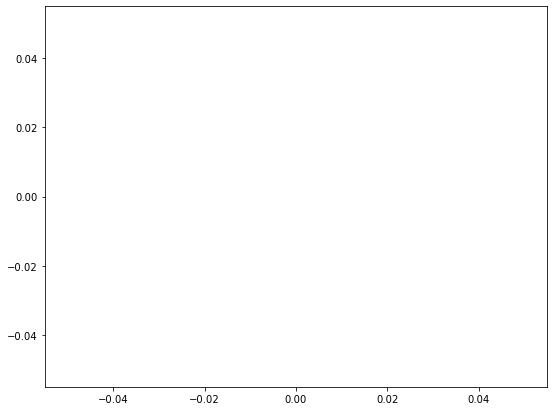

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Load data
with open("./out/data/" + "uniform_attack_epsilon", 'r') as f:
    df = pd.read_csv(f, index_col=0)

# Plot df
plt.figure(figsize=(9,7))
plt.plot(df.index, df['mean_rew'], color='darkslategray', alpha=1, zorder=0)
plt.vlines(df.index, ymin=0, ymax=df['mean_rew'], color=np.where(df['mean_rew'] < 0, 'maroon', 'darkgreen'), alpha=1, zorder=1)
plt.scatter(df.index, df['mean_rew'], color=np.where(df['mean_rew'] < 0, 'maroon', 'darkgreen'), label='mean reward', marker='D', alpha=1, zorder=2)

plt.plot(df.index, df['mean_perturbation'], label='mean perturbation', color='orange', linestyle='dotted', alpha=1, zorder=0)

plt.plot(df.index, df['mean_n_timesteps'], label='mean n timesteps', color='purple', linestyle='dashed', alpha=1, zorder=0)

plt.plot(df.index, df['mean_n_attacks'], label='mean n attacks', color='darkblue', linestyle='dashed', alpha=1, zorder=0)

plt.title("Uniform attack")
plt.legend()
plt.xlabel('$\epsilon$')
# plt.ylabel()
plt.axis([0, 1, -300, 500]) # plt.axis([xmin, xmax, ymin, ymax])
plt.show()

### Todo

- Run with different epsilon
- implement strategically timed attack, etc.